# Chile: best comuna to place a Coffee Shop
## Coursera IBM Data Science final Capstone project

### 1- Introduction/Business problem
I live in Chile and also love coffee. I've always dreamed about putting a Coffe shop somewhere, but of course the question that arise immediately is "where?". Here, I'll try to answer that question by using some of the techniques learned on this IBM Data Science courses.
Chile is subdivided on Regions and Comunas, being this Comunas as large Neighborhoods. Please, keep in mind that. 

I'll focus on the Metropolitan Region of Chile: is where I live and the one with the most variety of business and restaurants, and of course, coffee shops. Also, is the Region where the Capital belongs, Santiago de Chile, and the one with most income of all the country. But of course, the same analysis can be applied to a different Region on Chile or even a different country, since the algorithms that I'll apply will be, of couse, generic. The only thing that maybe will be different is the data treatment, but the methodology will be the same.

### 2-Data Description
To solve the business problem described above, I'll work with the following data:
- A Wikipedia page where is the info I need: Latitude and Longitude for each Comuna in Chile, divided by Region. The page is the following: https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile
- Also, on this table, there are two more indicators tha will help me on my analysis: the Population Density (Habitants/Km^2) and the IDH (Indice de Desarrollo Humano or Human Development Index). The Density will help me to know and approximate of how many Coffee shops per habitant are there, and the IDH will help me to choose the Comuna with better incomes, since one of the indicators for that number is precisely that one. Also, the comunas with better IDH have better infraestructure, more educated habitants and more tourism, which is better for a Coffe shop.
- I'll also use the foursquare data to get, by comuna, the most common venues and then, by using K-means algorithm, group the comunas and choose the one that looks best to place the Coffee shop. Then, I'll work with the most representative group and get the number of Coffee shops existant (using again Foursquare data), get the number of coffee shops per habitant and with that number, choose the best comuna to place my shop.

I'll be using maps to visualize, first, all the comunas in the Metropolitan region and then the ones that I'll use, and also to visualize the cluster generated by the K-means algorithm. To finally make my choice I think that maybe a Choropleth map will be useful, or maybe a Horizontal plot bar will be enough: Whatever suits best to show the results to the stakeholders.

### 3-Methodoly

As I already said above, I'm going to use the data available on a wikipedia, which has the geo coordinates for each Comuna and also other data that it's interesting for me to use.

First, import the necessary libraries:

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from sklearn.cluster import KMeans
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Now, I'm going to use Beautiful Soup with Pandas to get the table from the Wikipedia page and transform it into a Pandas Dataframe:

In [2]:
res = requests.get("https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile")
soup = BeautifulSoup(res.content,'html')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]
df.head()

,CUT (Código Único Territorial),Nombre,Unnamed: 2,Provincia,Región,Superficie(km²),Población2020,Densidad(hab./km²),IDH 2020,IDH 2020.1,Latitud,Longitud
0,15101,Arica,NaN,Arica,Arica y Parinacota,4.7994,247.552,51.60,0.866,Alto,"-18°27'18""","-70°17'24"""
1,15102,Camarones,NaN,Arica,Arica y Parinacota,3.927,1.233,0.31,0.791,Alto,"-19°1'1.2""","-69°52'1.2"""
2,15201,Putre,NaN,Parinacota,Arica y Parinacota,5.9025,2.515,0.43,0.817,Alto,"-18°12'0""","-69°34'58.8"""
3,15202,General Lagos,NaN,Parinacota,Arica y Parinacota,2.2444,810.000,0.36,0.773,Medio,"-17°39'10.8""","-69°38'6"""
4,1101,Iquique,NaN,Iquique,Tarapacá,2.2421,223.463,996.00,0.826,Alto,"-20°14'38.4""","-70°8'20.4"""


OK, looks good, but not good enough. On the next step, I'm going to clean up a bit the Dataframe, deleting unnecessary columns and rename others for better habndling.

In [3]:
# Deleting some columns...
df.drop(["CUT (Código Único Territorial)","Unnamed: 2","Provincia","Superficie(km²)","Población2020","IDH 2020"],axis=1,inplace=True)
# renaming...
df.rename(columns = {'Nombre':'Comuna','Región':'Region', 'Densidad(hab./km²)':'Densidad','IDH 2020.1':'IDH'}, inplace = True)
df.head()

,Comuna,Region,Densidad,IDH,Latitud,Longitud
0,Arica,Arica y Parinacota,51.60,Alto,"-18°27'18""","-70°17'24"""
1,Camarones,Arica y Parinacota,0.31,Alto,"-19°1'1.2""","-69°52'1.2"""
2,Putre,Arica y Parinacota,0.43,Alto,"-18°12'0""","-69°34'58.8"""
3,General Lagos,Arica y Parinacota,0.36,Medio,"-17°39'10.8""","-69°38'6"""
4,Iquique,Tarapacá,996.00,Alto,"-20°14'38.4""","-70°8'20.4"""


That's better. But there's still one problem: the Latitude and Longitude on the DF is in degrees, minutes, seconds format. To make it work with Foursquare, I need it to be in decinal format. So, I'm going to change it: first, creating a function to do that and then applying it to the corresponding columns:

In [4]:
# Function to change the value of Lat and Long from degrees to decimal format.
def grados_a_decimal(valor):
    delimitador_parte_entera=valor.find("°")
    parte_entera=valor[0:delimitador_parte_entera]
    delimitador_minutos=valor.find("'")
    minutos=valor[delimitador_parte_entera+1:delimitador_minutos]
    delimitador_segundos=valor.find('"')
    segundos=valor[delimitador_minutos+1:delimitador_segundos]
    valor_decimal=float(parte_entera)-float(minutos)/60-float(segundos)/3600
    return valor_decimal

In [5]:
# Applying the function to the corresponding columns
df['Latitud'] = df['Latitud'].apply(lambda x: grados_a_decimal(x))
df['Longitud'] = df['Longitud'].apply(lambda x: grados_a_decimal(x))
df.head()

,Comuna,Region,Densidad,IDH,Latitud,Longitud
0,Arica,Arica y Parinacota,51.60,Alto,-18.455,-70.290
1,Camarones,Arica y Parinacota,0.31,Alto,-19.017,-69.867
2,Putre,Arica y Parinacota,0.43,Alto,-18.200,-69.583
3,General Lagos,Arica y Parinacota,0.36,Medio,-17.653,-69.635
4,Iquique,Tarapacá,996.00,Alto,-20.244,-70.139


Done! I'm ready to select the Region in what I'm interested to work, which is the Region Metropolitana. So, let's select a subset of the whole Dataframe to work with.

In [6]:
df_metropolitana = df[df['Region'] == "Metropolitana de Santiago"].reset_index(drop=True)
df_metropolitana.head()

,Comuna,Region,Densidad,IDH,Latitud,Longitud
0,Santiago,Metropolitana de Santiago,21.8759,Muy alto,-33.437222,-70.657222
1,Cerrillos,Metropolitana de Santiago,4.2360,Alto,-33.500000,-70.716667
2,Cerro Navia,Metropolitana de Santiago,12.9513,Medio,-33.422000,-70.735000
3,Conchalí,Metropolitana de Santiago,12.6540,Alto,-33.380000,-70.675000
4,El Bosque,Metropolitana de Santiago,12.2857,Alto,-33.567000,-70.675000


Let's check how many rows are in our new dataframe:

In [7]:
df_metropolitana.shape

(52, 6)

Nice. 52 is correct, that's the total number of Comunas on the Region Metropolitana. 

Now, let's visualize the data a little bit. How about checking the comunas on a map, to check how centered they are, and more important, let's put a different color to identify them by the IDH factor. Let's translate it the range a little bit:
- Muy Alto: Very high - Blue
- Alto: High - Green
- Medio: Medium - Yellow
- Bajo: Low - Orange

In [8]:
latitude=-33.6027831
longitude=-71.299166

map_metropolitana = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, label, idh in zip(df_metropolitana['Latitud'], df_metropolitana['Longitud'], df_metropolitana['Comuna'], df_metropolitana['IDH']):
    label = folium.Popup(label, parse_html=True)
    if idh == 'Muy alto': color='blue'
    elif idh == 'Alto': color='green'
    elif idh == 'Medio': color='yellow'
    else: color='orange' 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(map_metropolitana)

map_metropolitana

OK, looks good, but I need to filter a little bit more the data. First, I'm interested only in the Comunas that have 'High' or 'Very high' IDH, so, lets filter them:

In [9]:
df_metropolitana = df_metropolitana.query('IDH == "Muy alto" or IDH == "Alto"').reset_index(drop=True)
df_metropolitana.shape

(45, 6)

OK, only. 7 comunas has an IDH lower than 'High'.

The other issue is that the Region Metropolitana has a very extensive territory, and I'm not particularly interested in the Comunas that are too far away from the center of the Region, since this Comunas are considered more "Rural", so, the people living there are not particularly a target for a Coffee shop. So. lets' eliminate them:

In [10]:
df_metropolitana = df_metropolitana.query('Latitud > -33.59 and Latitud < -33.34 and Longitud >-70.79 and Longitud < -70.5').reset_index(drop=True)
df_metropolitana.shape

(28, 6)

OK! I have cut down 24 Comunas, and I'm ready to work with the remaining 28. Let's visualize them on a map again:

In [11]:
map_metropolitana = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, idh in zip(df_metropolitana['Latitud'], df_metropolitana['Longitud'], df_metropolitana['Comuna'], df_metropolitana['IDH']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(map_metropolitana)

map_metropolitana

OK, Now I'm ready to have fun with Foursquare. First, lets' initialize some useful variables:

In [57]:
# Here are the credentials, remove the info to upload the file.

In [13]:
VERSION = '20201229' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

First, I'm going to reuse a function from the lectures where we get the nearby venues given a location. Instead of use 500 m around, we are going to go a little bit bigger: 5 km. Why? because, as I said on the Introduction part, Comunas are like LARGE neighborhoods. So, in average, I think that look at the locations around 5 km is good to get enough information.

In [16]:
# using the function of the lab
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Comuna', 
                  'Comuna Latitude', 
                  'Comuna Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']  
    return(nearby_venues)

OK, let's use the function to get the venues:

In [17]:
metropolitana_venues = getNearbyVenues(names=df_metropolitana['Comuna'],
                                   latitudes=df_metropolitana['Latitud'],
                                   longitudes=df_metropolitana['Longitud']
                                  )

In [18]:
metropolitana_venues

,Comuna,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santiago,-33.437222,-70.657222,Plaza de Bolsillo - Santiago Centro,-33.436778,-70.655481,Plaza
1,Santiago,-33.437222,-70.657222,FuriSushi,-33.436130,-70.662690,Sushi Restaurant
2,Santiago,-33.437222,-70.657222,La Fête Chocolat,-33.442606,-70.651286,Candy Store
3,Santiago,-33.437222,-70.657222,Libreria Manantial,-33.438549,-70.651361,College Bookstore
4,Santiago,-33.437222,-70.657222,Starbucks,-33.433253,-70.658200,Coffee Shop
...,...,...,...,...,...,...,...
2724,San Bernardo,-33.582000,-70.687000,Hiper Lider,-33.546332,-70.667430,Supermarket
2725,San Bernardo,-33.582000,-70.687000,Feria San Rafael,-33.581776,-70.638947,Farmers Market
2726,San Bernardo,-33.582000,-70.687000,"Metro de Santiago, Línea 4A",-33.564491,-70.641212,Metro Station
2727,San Bernardo,-33.582000,-70.687000,Plaza Prat,-33.547001,-70.657854,Plaza


Let's count how many venues we got for each Comuna:

In [20]:
metropolitana_venues.groupby('Comuna').count()

,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Comuna,,,,,,
Cerrillos,100,100,100,100,100,100
Conchalí,100,100,100,100,100,100
El Bosque,100,100,100,100,100,100
Estación Central,100,100,100,100,100,100
Huechuraba,100,100,100,100,100,100
Independencia,100,100,100,100,100,100
La Cisterna,54,54,54,54,54,54
La Florida,100,100,100,100,100,100
La Reina,100,100,100,100,100,100


Let's find out how many categories we got:

In [21]:
print('There are {} uniques categories.'.format(len(metropolitana_venues['Venue Category'].unique())))

There are 230 uniques categories.


OK, now let's prepare the data to work with the K-means algorithm and let the machine learning do their magic to group our Comunas and find out which ones are more suitable for our Coffee shop.
First, let's transform the data into Onehot Encoding:

In [22]:
metropolitana_onehot = pd.get_dummies(metropolitana_venues[['Venue Category']], prefix="", prefix_sep="")
metropolitana_onehot.insert(0, "Comuna", metropolitana_venues['Comuna'], True)
metropolitana_onehot.head()

,Comuna,Accessories Store,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Vineyard,Volleyball Court,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's group by the Dataframe by Comuna by taking the mean on each category:

In [23]:
metropolitana_grouped=metropolitana_onehot.groupby('Comuna').mean().reset_index()
metropolitana_grouped

,Comuna,Accessories Store,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Vineyard,Volleyball Court,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Cerrillos,0.00,0.01,0.000000,0.00,0.00,0.00,0.01,0.00,0.000000,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Conchalí,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2,El Bosque,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.010000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Estación Central,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00
4,Huechuraba,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
5,Independencia,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.010000,...,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00
6,La Cisterna,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.018519,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,La Florida,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
8,La Reina,0.00,0.00,0.010000,0.01,0.00,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
9,Las Condes,0.00,0.00,0.010000,0.00,0.00,0.00,0.00,0.00,0.010000,...,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00


OK, looks good. With this data frame I'm ready to get the 10 most common venues by Comuna. So let's define a function to do that:

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

And now we use it:

In [27]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Comuna']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
comuna_venues_sorted = pd.DataFrame(columns=columns)
comuna_venues_sorted['Comuna'] = metropolitana_grouped['Comuna']

for ind in np.arange(metropolitana_grouped.shape[0]):
    comuna_venues_sorted.iloc[ind, 1:] = return_most_common_venues(metropolitana_grouped.iloc[ind, :], num_top_venues)

comuna_venues_sorted.head()

,Comuna,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cerrillos,Sushi Restaurant,Chinese Restaurant,Gym,Sandwich Place,Ice Cream Shop,Park,Restaurant,Pizza Place,Coffee Shop,Department Store
1,Conchalí,Furniture / Home Store,Sushi Restaurant,Sandwich Place,Soccer Field,Peruvian Restaurant,Chinese Restaurant,Convenience Store,Fast Food Restaurant,Café,Bakery
2,El Bosque,Chinese Restaurant,Pizza Place,Sushi Restaurant,Seafood Restaurant,Pharmacy,Flea Market,Gym,Burger Joint,Bar,Bakery
3,Estación Central,Sushi Restaurant,Sandwich Place,Peruvian Restaurant,Park,Plaza,Coffee Shop,Bakery,History Museum,Restaurant,South American Restaurant
4,Huechuraba,Peruvian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Coffee Shop,Burger Joint,Soccer Field,Spa,Bakery,Park


Finally, now that we have the 10 more common venue types by comuna sorted, we can use the K-means algorithm to let it group automatically the Comunas.

In [28]:
# set number of clusters
kclusters = 5
metropolitana_grouped_clustering = metropolitana_grouped.drop('Comuna', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(metropolitana_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 4, 0, 2, 4, 2, 3, 0, 1, 1, 1, 2, 2, 0, 1, 4, 1, 2, 4, 2, 1, 0,
       0, 2, 2, 2, 1, 1], dtype=int32)

Good. We have our groups. Let's add them to a DataFrame:

In [29]:
# adding the cluster labels
comuna_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
metropolitana_merged = df_metropolitana

# Let's use right join, just in case not all the Comunas on the df_metropolitana are on the comunas_venues_sorted
metropolitana_merged = metropolitana_merged.join(comuna_venues_sorted.set_index('Comuna'), on='Comuna',how='right')

metropolitana_merged.head()

,Comuna,Region,Densidad,IDH,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Santiago,Metropolitana de Santiago,21.8759,Muy alto,-33.437222,-70.657222,2,Park,Coffee Shop,Pizza Place,Theater,Sushi Restaurant,Farmers Market,Tea Room,Restaurant,Bakery,Neighborhood
1,Cerrillos,Metropolitana de Santiago,4.2360,Alto,-33.500000,-70.716667,0,Sushi Restaurant,Chinese Restaurant,Gym,Sandwich Place,Ice Cream Shop,Park,Restaurant,Pizza Place,Coffee Shop,Department Store
2,Conchalí,Metropolitana de Santiago,12.6540,Alto,-33.380000,-70.675000,4,Furniture / Home Store,Sushi Restaurant,Sandwich Place,Soccer Field,Peruvian Restaurant,Chinese Restaurant,Convenience Store,Fast Food Restaurant,Café,Bakery
3,El Bosque,Metropolitana de Santiago,12.2857,Alto,-33.567000,-70.675000,0,Chinese Restaurant,Pizza Place,Sushi Restaurant,Seafood Restaurant,Pharmacy,Flea Market,Gym,Burger Joint,Bar,Bakery
4,Estación Central,Metropolitana de Santiago,13.7861,Alto,-33.459000,-70.699000,2,Sushi Restaurant,Sandwich Place,Peruvian Restaurant,Park,Plaza,Coffee Shop,Bakery,History Museum,Restaurant,South American Restaurant


Let's visualize it again this result on a Folium map:

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(metropolitana_merged['Latitud'], metropolitana_merged['Longitud'], metropolitana_merged['Comuna'], metropolitana_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Good. Let's examine the clusters to have a better idea of which one is the best candidate for our business:

#### Cluster 0
More focused on Oriental restaurants and pizza places, I think we can discard this one.

In [32]:
metropolitana_merged.loc[metropolitana_merged['Cluster Labels'] == 0, metropolitana_merged.columns[[0] + list(range(5, metropolitana_merged.shape[1]))]]

,Comuna,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Cerrillos,-70.716667,0,Sushi Restaurant,Chinese Restaurant,Gym,Sandwich Place,Ice Cream Shop,Park,Restaurant,Pizza Place,Coffee Shop,Department Store
3,El Bosque,-70.675000,0,Chinese Restaurant,Pizza Place,Sushi Restaurant,Seafood Restaurant,Pharmacy,Flea Market,Gym,Burger Joint,Bar,Bakery
8,La Florida,-70.538000,0,Sushi Restaurant,Chinese Restaurant,Pizza Place,Gym,Bakery,Restaurant,Snack Place,Soccer Stadium,Peruvian Restaurant,Park
14,Maipú,-70.766667,0,Sushi Restaurant,Bar,Park,Pizza Place,Sandwich Place,Chinese Restaurant,Breakfast Spot,Department Store,Burger Joint,Restaurant
23,Renca,-70.723000,0,Restaurant,Sushi Restaurant,Pharmacy,Chinese Restaurant,Park,Bar,Gym,BBQ Joint,Pizza Place,Sandwich Place
27,San Bernardo,-70.687000,0,Pizza Place,Chinese Restaurant,Flea Market,Park,Sushi Restaurant,Plaza,Farmers Market,Italian Restaurant,Japanese Restaurant,Liquor Store


#### Cluster 1
This is more interesting cluster, where all the comunas have a Coffee Shop on the top 5 most common venues. Also, we see a lots of Bakery shops and nonetheless, parks and gyms, where our target audience usually hangs out.

In [33]:
metropolitana_merged.loc[metropolitana_merged['Cluster Labels'] == 1, metropolitana_merged.columns[[0] + list(range(5, metropolitana_merged.shape[1]))]]

,Comuna,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,La Reina,-70.532000,1,Bakery,Coffee Shop,Restaurant,Plaza,Park,Farmers Market,Multiplex,Gym / Fitness Center,Pizza Place,Spa
10,Las Condes,-70.583333,1,Hotel,Coffee Shop,Bakery,Park,Plaza,Café,Peruvian Restaurant,Spa,Ice Cream Shop,Japanese Restaurant
11,Lo Barnechea,-70.516667,1,Gym,Restaurant,Park,Bakery,Coffee Shop,Shopping Mall,Golf Course,Plaza,Mountain,Pizza Place
15,Ñuñoa,-70.604000,1,Bakery,Peruvian Restaurant,Coffee Shop,Sandwich Place,Plaza,Italian Restaurant,Park,Restaurant,Pizza Place,Ice Cream Shop
16,Pedro Aguirre Cerda,-70.633667,1,Park,Bakery,Peruvian Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Restaurant,Bar,Sandwich Place,Candy Store
18,Providencia,-70.616000,1,Park,Bakery,Coffee Shop,Peruvian Restaurant,Sandwich Place,Restaurant,Scenic Lookout,Hotel,Bar,Vegetarian / Vegan Restaurant
22,Recoleta,-70.640000,1,Park,Coffee Shop,Scenic Lookout,Hotel,Restaurant,Farmers Market,Tea Room,Liquor Store,Sandwich Place,Seafood Restaurant
26,Vitacura,-70.600000,1,Hotel,Park,Restaurant,Coffee Shop,Sandwich Place,Scenic Lookout,Gym / Fitness Center,Plaza,Ice Cream Shop,Peruvian Restaurant


#### Cluster 2
Again, and interesting group, with Coffee shops on the top 5. But, we don't see a lots of parks here, more like oriental restaurants again.

In [34]:
metropolitana_merged.loc[metropolitana_merged['Cluster Labels'] == 2, metropolitana_merged.columns[[0] + list(range(5, metropolitana_merged.shape[1]))]]

,Comuna,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Santiago,-70.657222,2,Park,Coffee Shop,Pizza Place,Theater,Sushi Restaurant,Farmers Market,Tea Room,Restaurant,Bakery,Neighborhood
4,Estación Central,-70.699000,2,Sushi Restaurant,Sandwich Place,Peruvian Restaurant,Park,Plaza,Coffee Shop,Bakery,History Museum,Restaurant,South American Restaurant
6,Independencia,-70.666000,2,Park,Coffee Shop,Pizza Place,Tea Room,Farmers Market,Theater,Plaza,Sushi Restaurant,Restaurant,Sandwich Place
12,Lo Prado,-70.726000,2,Sushi Restaurant,Sandwich Place,Chinese Restaurant,Bakery,Nightclub,Pizza Place,Restaurant,Food Truck,Performing Arts Venue,Gym
13,Macul,-70.604000,2,Sandwich Place,Sushi Restaurant,Peruvian Restaurant,Coffee Shop,Ice Cream Shop,Bakery,Farmers Market,Café,Pizza Place,Park
19,Pudahuel,-70.716667,2,Sushi Restaurant,Peruvian Restaurant,Bakery,Nightclub,Bar,Sandwich Place,Gym,Food Truck,Coffee Shop,Restaurant
21,Quinta Normal,-70.699000,2,Sushi Restaurant,Coffee Shop,Sandwich Place,Peruvian Restaurant,Bar,Restaurant,Park,Plaza,Farmers Market,Food Truck
24,San Joaquín,-70.628000,2,Sushi Restaurant,Bakery,Pizza Place,Sandwich Place,Coffee Shop,Park,Italian Restaurant,Peruvian Restaurant,Plaza,Ice Cream Shop
25,San Miguel,-70.649444,2,Pizza Place,Sushi Restaurant,Sandwich Place,Bakery,Peruvian Restaurant,Coffee Shop,Park,Japanese Restaurant,Restaurant,Ice Cream Shop


#### Cluster 3
I thon we can discard this comuna, no Coffee shops here, more oriental restaurants and pizza places.

In [35]:
metropolitana_merged.loc[metropolitana_merged['Cluster Labels'] == 3, metropolitana_merged.columns[[0] + list(range(5, metropolitana_merged.shape[1]))]]

,Comuna,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,La Cisterna,-70.663,3,Sushi Restaurant,Park,Pizza Place,Bar,Bakery,Liquor Store,Gym / Fitness Center,Fast Food Restaurant,Brewery,Burger Joint


#### Cluster 4
The last cluster is again not interesting. Seems to be more focused on a more 'family' kind of people, and the Coffee shops are only at the 5th most common value and below. We can discard this one.

In [36]:
metropolitana_merged.loc[metropolitana_merged['Cluster Labels'] == 4, metropolitana_merged.columns[[0] + list(range(5, metropolitana_merged.shape[1]))]]

,Comuna,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Conchalí,-70.675000,4,Furniture / Home Store,Sushi Restaurant,Sandwich Place,Soccer Field,Peruvian Restaurant,Chinese Restaurant,Convenience Store,Fast Food Restaurant,Café,Bakery
5,Huechuraba,-70.634000,4,Peruvian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Coffee Shop,Burger Joint,Soccer Field,Spa,Bakery,Park
17,Peñalolén,-70.533333,4,Pizza Place,Farmers Market,Restaurant,Sushi Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Food Truck,Park,Garden Center
20,Quilicura,-70.729000,4,Clothing Store,Sushi Restaurant,Furniture / Home Store,Department Store,Restaurant,Ice Cream Shop,Soccer Field,Chinese Restaurant,Pharmacy,Donut Shop


The way I see it, the real fight is between Cluster 1 and 2, But I'll choose cluster 1 because the other popular places are more like to have people interested in attend a Coffee shop. The presence of Gyms, parks and Hotels tips the scales on it's favor. So, let's work with it.

In [37]:
best_cluster=metropolitana_merged.loc[metropolitana_merged['Cluster Labels'] == 1].reset_index(drop=True)
best_cluster

,Comuna,Region,Densidad,IDH,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,La Reina,Metropolitana de Santiago,4.3587,Muy alto,-33.443000,-70.532000,1,Bakery,Coffee Shop,Restaurant,Plaza,Park,Farmers Market,Multiplex,Gym / Fitness Center,Pizza Place,Spa
1,Las Condes,Metropolitana de Santiago,3.3410,Muy alto,-33.416667,-70.583333,1,Hotel,Coffee Shop,Bakery,Park,Plaza,Café,Peruvian Restaurant,Spa,Ice Cream Shop,Japanese Restaurant
2,Lo Barnechea,Metropolitana de Santiago,121.1000,Muy alto,-33.350000,-70.516667,1,Gym,Restaurant,Park,Bakery,Coffee Shop,Shopping Mall,Golf Course,Plaza,Mountain,Pizza Place
3,Ñuñoa,Metropolitana de Santiago,14.7171,Muy alto,-33.454000,-70.604000,1,Bakery,Peruvian Restaurant,Coffee Shop,Sandwich Place,Plaza,Italian Restaurant,Park,Restaurant,Pizza Place,Ice Cream Shop
4,Pedro Aguirre Cerda,Metropolitana de Santiago,10.7803,Alto,-33.466333,-70.633667,1,Park,Bakery,Peruvian Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Restaurant,Bar,Sandwich Place,Candy Store
5,Providencia,Metropolitana de Santiago,11.2677,Muy alto,-33.435000,-70.616000,1,Park,Bakery,Coffee Shop,Peruvian Restaurant,Sandwich Place,Restaurant,Scenic Lookout,Hotel,Bar,Vegetarian / Vegan Restaurant
6,Recoleta,Metropolitana de Santiago,11.8793,Alto,-33.406000,-70.640000,1,Park,Coffee Shop,Scenic Lookout,Hotel,Restaurant,Farmers Market,Tea Room,Liquor Store,Sandwich Place,Seafood Restaurant
7,Vitacura,Metropolitana de Santiago,3.4562,Muy alto,-33.400000,-70.600000,1,Hotel,Park,Restaurant,Coffee Shop,Sandwich Place,Scenic Lookout,Gym / Fitness Center,Plaza,Ice Cream Shop,Peruvian Restaurant


Let's define a function to get the number of Coffee shops for each comuna selected:

In [39]:
# function to get the list of number of coffe shops on the Comunas selected, on a radius of 5k
def getCoffeShopsNumber(names, latitudes, longitudes, radius=5000):
    coffee_shops_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        search_category = '4bf58dd8d48988d1e0931735' #category for #coffee shop
        
        url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            search_category, 
            radius, 
            LIMIT)

        number_of_coffeshops = requests.get(url).json()["response"]['totalResults']
        coffee_shops_list.append(number_of_coffeshops)
        
    return(coffee_shops_list)

In [40]:
coffee_shops_list=getCoffeShopsNumber(names=best_cluster['Comuna'],
                                   latitudes=best_cluster['Latitud'],
                                   longitudes=best_cluster['Longitud']
                                  )

In [41]:
best_cluster['Coffee Shops N']=coffee_shops_list
best_cluster

,Comuna,Region,Densidad,IDH,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shops N
0,La Reina,Metropolitana de Santiago,4.3587,Muy alto,-33.443000,-70.532000,1,Bakery,Coffee Shop,Restaurant,Plaza,Park,Farmers Market,Multiplex,Gym / Fitness Center,Pizza Place,Spa,116
1,Las Condes,Metropolitana de Santiago,3.3410,Muy alto,-33.416667,-70.583333,1,Hotel,Coffee Shop,Bakery,Park,Plaza,Café,Peruvian Restaurant,Spa,Ice Cream Shop,Japanese Restaurant,113
2,Lo Barnechea,Metropolitana de Santiago,121.1000,Muy alto,-33.350000,-70.516667,1,Gym,Restaurant,Park,Bakery,Coffee Shop,Shopping Mall,Golf Course,Plaza,Mountain,Pizza Place,11
3,Ñuñoa,Metropolitana de Santiago,14.7171,Muy alto,-33.454000,-70.604000,1,Bakery,Peruvian Restaurant,Coffee Shop,Sandwich Place,Plaza,Italian Restaurant,Park,Restaurant,Pizza Place,Ice Cream Shop,114
4,Pedro Aguirre Cerda,Metropolitana de Santiago,10.7803,Alto,-33.466333,-70.633667,1,Park,Bakery,Peruvian Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Restaurant,Bar,Sandwich Place,Candy Store,90
5,Providencia,Metropolitana de Santiago,11.2677,Muy alto,-33.435000,-70.616000,1,Park,Bakery,Coffee Shop,Peruvian Restaurant,Sandwich Place,Restaurant,Scenic Lookout,Hotel,Bar,Vegetarian / Vegan Restaurant,127
6,Recoleta,Metropolitana de Santiago,11.8793,Alto,-33.406000,-70.640000,1,Park,Coffee Shop,Scenic Lookout,Hotel,Restaurant,Farmers Market,Tea Room,Liquor Store,Sandwich Place,Seafood Restaurant,58
7,Vitacura,Metropolitana de Santiago,3.4562,Muy alto,-33.400000,-70.600000,1,Hotel,Park,Restaurant,Coffee Shop,Sandwich Place,Scenic Lookout,Gym / Fitness Center,Plaza,Ice Cream Shop,Peruvian Restaurant,33


Now, let's make the calculation of roughly, amount of coffee shops per habitants, using the 'Densidad' (Density) value:

In [42]:
# making the calculation: we're going to divide the number of coffee shops by the density of each Comuna, to check how many coffee shops are per habitant
coffee_shops_per_hab=[]
for densidad,coffee_shops in zip(best_cluster['Densidad'],best_cluster['Coffee Shops N']):
    coffee_shops_per_hab.append(coffee_shops/densidad)

best_cluster['Coffee Shops per Habitant']=coffee_shops_per_hab

best_cluster

,Comuna,Region,Densidad,IDH,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shops N,Coffee Shops per Habitant
0,La Reina,Metropolitana de Santiago,4.3587,Muy alto,-33.443000,-70.532000,1,Bakery,Coffee Shop,Restaurant,Plaza,Park,Farmers Market,Multiplex,Gym / Fitness Center,Pizza Place,Spa,116,26.613440
1,Las Condes,Metropolitana de Santiago,3.3410,Muy alto,-33.416667,-70.583333,1,Hotel,Coffee Shop,Bakery,Park,Plaza,Café,Peruvian Restaurant,Spa,Ice Cream Shop,Japanese Restaurant,113,33.822209
2,Lo Barnechea,Metropolitana de Santiago,121.1000,Muy alto,-33.350000,-70.516667,1,Gym,Restaurant,Park,Bakery,Coffee Shop,Shopping Mall,Golf Course,Plaza,Mountain,Pizza Place,11,0.090834
3,Ñuñoa,Metropolitana de Santiago,14.7171,Muy alto,-33.454000,-70.604000,1,Bakery,Peruvian Restaurant,Coffee Shop,Sandwich Place,Plaza,Italian Restaurant,Park,Restaurant,Pizza Place,Ice Cream Shop,114,7.746091
4,Pedro Aguirre Cerda,Metropolitana de Santiago,10.7803,Alto,-33.466333,-70.633667,1,Park,Bakery,Peruvian Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Restaurant,Bar,Sandwich Place,Candy Store,90,8.348562
5,Providencia,Metropolitana de Santiago,11.2677,Muy alto,-33.435000,-70.616000,1,Park,Bakery,Coffee Shop,Peruvian Restaurant,Sandwich Place,Restaurant,Scenic Lookout,Hotel,Bar,Vegetarian / Vegan Restaurant,127,11.271156
6,Recoleta,Metropolitana de Santiago,11.8793,Alto,-33.406000,-70.640000,1,Park,Coffee Shop,Scenic Lookout,Hotel,Restaurant,Farmers Market,Tea Room,Liquor Store,Sandwich Place,Seafood Restaurant,58,4.882443
7,Vitacura,Metropolitana de Santiago,3.4562,Muy alto,-33.400000,-70.600000,1,Hotel,Park,Restaurant,Coffee Shop,Sandwich Place,Scenic Lookout,Gym / Fitness Center,Plaza,Ice Cream Shop,Peruvian Restaurant,33,9.548059


OK, we got everything we need to make our final decision. Let's plot the results:

In [54]:
df_plot=best_cluster[['Comuna','Coffee Shops per Habitant']]
df_plot.set_index('Comuna',inplace=True)
df_plot=df_plot.sort_values(by='Coffee Shops per Habitant', ascending=True)
df_plot

,Coffee Shops per Habitant
Comuna,
Lo Barnechea,0.090834
Recoleta,4.882443
Ñuñoa,7.746091
Pedro Aguirre Cerda,8.348562
Vitacura,9.548059
Providencia,11.271156
La Reina,26.613440
Las Condes,33.822209


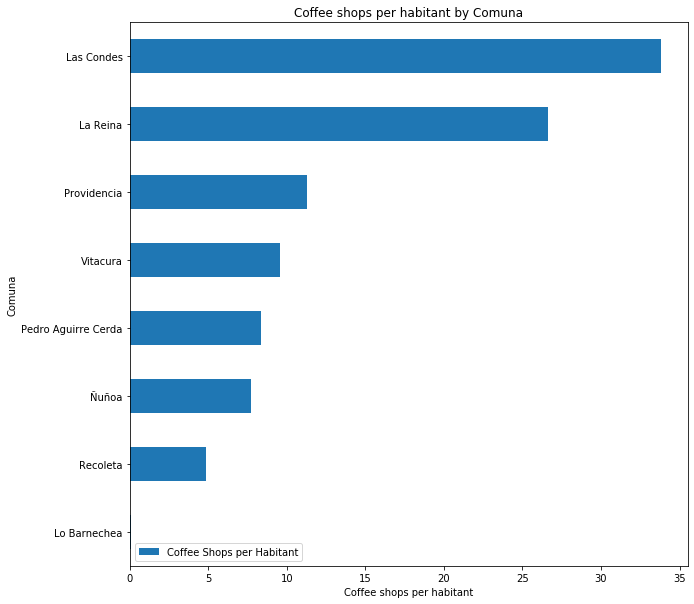

In [55]:
df_plot.plot(kind='barh', figsize=(10, 10)) 

plt.xlabel('Coffee shops per habitant')
plt.title('Coffee shops per habitant by Comuna')
    
plt.show()

OK. The amount of Coffee shops per habitan on Lo Barnechea is almost inexistant compare to the other Comunas, so, they are in clearly need for another one!

### 4- Results
After all the analysis ran on this set of Data, we can say that the best comuna to place our Coffee shop business is Lo Barnechea, since the amount of Coffee shops per habitant is surprisingly low in comparission with the other comunas on the same cluster.

Nowing a little bit abot the Comunas of the Region Metropolitana, I can say that this resuls are good enough, because on this case, Lo Barnechea has more or less the same incomes than the other comunas on the same cluster, like Las Condes or Vitacura, and the population on this Comunas are likely to share the same interest. Also, it has an IDH of 'Very high', so it's a good candidate enough. The exact location of the place is, of course, something to analyze further.

### 5- Discussion
Seeing the results, as I already said, the look good enough, but maybe the only thing that can be holds again the decision of putting the Coffee shop on Lo Barnechea is the distance of the comuna from the center of the Region. This Comuna is on the far-east of the Metropolitan region and is not a very good candidate if you want something near to the business center of Santiago. But, in that case, we can check the other Comunas that follow in the ranking, Recoleta and Ñuñoa, and they are very good candidates as well. So, in case that the stakeholders found that Lo Barnechea is located too far away, they can go and put the Coffee shop on Recoleta or Ñuñoa and the results will be similar.

Another thing that catch my attention was the low amount of data available on Foursquare for other regions in Chile. When I was doing this analysis I also tried on the regions of Valparaiso and O'higgins, but the amount of venues that I could get on Foursquare for that were too low, making the step of grouping by using the K-means algorithm was not clear enough to me. But, maybe with more data available, we'll be able to aplly the same methodology to any Region in Chile and maybe any city in the word.

### 6- Conclusion
The result of this report can be discussed further, and the exact location for the business place still needs to be analyzed, but I think that the methodology applied here can be used for almost any type of business and on every place in the world, that have, of course, a decent amount of data on Foursquare.
For the business problem studied here, the results are pretty good enough, and I'm happy with them. Being me the stakeholder, I approve the results obtained.